## MNIST Handwritten Digits Classification Experiment

This demo shows how you can use SageMaker Experiment Management Python SDK to organize, track, compare, and evaluate your machine learning (ML) model training experiments.

You can track artifacts for experiments, including data sets, algorithms, hyper-parameters, and metrics. Experiments executed on SageMaker such as SageMaker Autopilot jobs and training jobs will be automatically tracked. You can also track artifacts for additional steps within an ML workflow that come before/after model training e.g. data pre-processing or post-training model evaluation.

The APIs also let you search and browse your current and past experiments, compare experiments, and identify best performing models.

Now we will demonstrate these capabilities through an MNIST handwritten digits classification example. The experiment will be organized as follow:

1. Download and prepare the MNIST dataset.
2. Train a Convolutional Neural Network (CNN) Model. Tune the hyper parameter that configures the number of hidden channels in the model. Track the parameter configurations and resulting model accuracy using SageMaker Experiments Python SDK.
3. Finally use the search and analytics capabilities of Python SDK to search, compare and evaluate the performance of all model versions generated from model tuning in Step 2.
4. We will also see an example of tracing the complete linage of a model version i.e. the collection of all the data pre-processing and training configurations and inputs that went into creating that model version.

Make sure you selected `Python 3 (Data Science)` kernel.

### Install Python SDKs

In [23]:
import sys

In [24]:
!{sys.executable} -m pip install sagemaker-experiments

### Install PyTroch

In [25]:
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchvision

### Setup

In [26]:
import time

import boto3
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

In [42]:
sess = boto3.Session()
sm = sess.client('sagemaker')
role = get_execution_role()
bucket = Session().default_bucket()
prefix = 'mnist'

### Dataset
We download the MNIST hand written digits dataset, and then apply transformation on each of the image.

In [43]:
# download the dataset
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
train_set = datasets.MNIST('mnist', train=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]), 
    download=True)
                           
test_set = datasets.MNIST('mnist', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]),
    download=False)

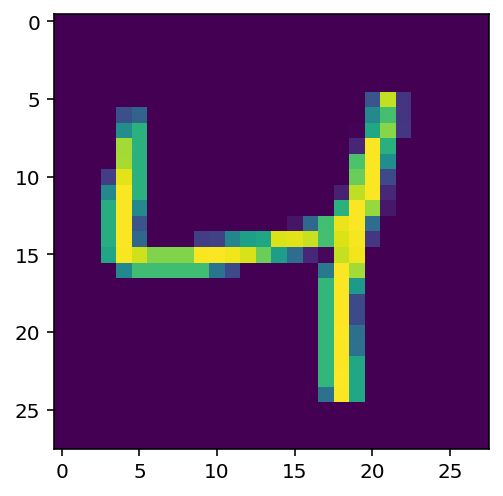

In [44]:
plt.imshow(train_set.data[2].numpy())

After transforming the images in the dataset, we upload it to s3.

In [45]:
inputs = sagemaker.Session().upload_data(path='mnist', bucket=bucket, key_prefix=prefix)
print('input spec: {}'.format(inputs))

input spec: s3://sagemaker-us-west-2-122554519915/mnist


Now lets track the parameters from the data pre-processing step.

In [46]:
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({
        "normalization_mean": 0.1307,
        "normalization_std": 0.3081,
    })
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="mnist-dataset", media_type="s3/uri", value=inputs)

### Step 1 - Set up the Experiment

Create an experiment to track all the model training iterations. Experiments are a great way to organize your data science work. You can create experiments to organize all your model development work for : [1] a business use case you are addressing (e.g. create experiment named “customer churn prediction”), or [2] a data science team that owns the experiment (e.g. create experiment named “marketing analytics experiment”), or [3] a specific data science and ML project. Think of it as a “folder” for organizing your “files”.

### Create an Experiment

In [47]:
mnist_experiment = Experiment.create(
    experiment_name=f"mnist-hand-written-digits-classification-{int(time.time())}", 
    description="Classification of mnist hand-written digits", 
    sagemaker_boto_client=sm)
print(mnist_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f2d061b0190>,experiment_name='mnist-hand-written-digits-classification-1594151366',description='Classification of mnist hand-written digits',experiment_arn='arn:aws:sagemaker:us-west-2:122554519915:experiment/mnist-hand-written-digits-classification-1594151366',response_metadata={'RequestId': '7510308b-1766-4173-80f3-fa558572c69c', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '7510308b-1766-4173-80f3-fa558572c69c', 'content-type': 'application/x-amz-json-1.1', 'content-length': '123', 'date': 'Tue, 07 Jul 2020 19:49:26 GMT'}, 'RetryAttempts': 0})


### Step 2 - Track Experiment
### Now create a Trial for each training run to track the it's inputs, parameters, and metrics.
While training the CNN model on SageMaker, we will experiment with several values for the number of hidden channel in the model. We will create a Trial to track each training job run. We will also create a TrialComponent from the tracker we created before, and add to the Trial. This will enrich the Trial with the parameters we captured from the data pre-processing stage.

Note the execution of the following code takes a while.

In [48]:
from sagemaker.pytorch import PyTorch, PyTorchModel

In [49]:
hidden_channel_trial_name_map = {}

If you want to run the following training jobs asynchronously, you may need to increase your resource limit. Otherwise, you can run them sequentially.

In [50]:
preprocessing_trial_component = tracker.trial_component

In [51]:
for i, num_hidden_channel in enumerate([2, 5, 10, 20, 32]):
    # create trial
    trial_name = f"cnn-training-job-{num_hidden_channel}-hidden-channels-{int(time.time())}"
    cnn_trial = Trial.create(
        trial_name=trial_name, 
        experiment_name=mnist_experiment.experiment_name,
        sagemaker_boto_client=sm,
    )
    hidden_channel_trial_name_map[num_hidden_channel] = trial_name
    
    # associate the proprocessing trial component with the current trial
    cnn_trial.add_trial_component(preprocessing_trial_component)
    
    # all input configurations, parameters, and metrics specified in estimator 
    # definition are automatically tracked
    estimator = PyTorch(
        entry_point='./mnist.py',
        role=role,
        sagemaker_session=sagemaker.Session(sagemaker_client=sm),
        framework_version='1.1.0',
        train_instance_count=1,
        train_instance_type='ml.c4.xlarge',
        hyperparameters={
            'epochs': 2,
            'backend': 'gloo',
            'hidden_channels': num_hidden_channel,
            'dropout': 0.2,
            'kernel_size': 5,
            'optimizer': 'sgd'
        },
        metric_definitions=[
            {'Name':'train:loss', 'Regex':'Train Loss: (.*?);'},
            {'Name':'test:loss', 'Regex':'Test Average loss: (.*?),'},
            {'Name':'test:accuracy', 'Regex':'Test Accuracy: (.*?)%;'}
        ],
        enable_sagemaker_metrics=True
    )
    
    cnn_training_job_name = "cnn-training-job-{}".format(int(time.time()))
    
    # Now associate the estimator with the Experiment and Trial
    estimator.fit(
        inputs={'training': inputs}, 
        job_name=cnn_training_job_name,
        experiment_config={
            "TrialName": cnn_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        },
        wait=True,
    )
    
    # give it a while before dispatching the next training job
    time.sleep(2)

INFO:sagemaker:Creating training-job with name: cnn-training-job-1594151377


2020-07-07 19:49:38 Starting - Starting the training job...
2020-07-07 19:49:40 Starting - Launching requested ML instances......
2020-07-07 19:50:48 Starting - Preparing the instances for training......
2020-07-07 19:52:05 Downloading - Downloading input data
2020-07-07 19:52:05 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-07 19:52:20,053 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-07 19:52:20,056 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-07 19:52:20,067 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-07 19:52:20,068 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-07 19:52:20,376 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2020-07-07 19:52:20,376

INFO:sagemaker:Creating training-job with name: cnn-training-job-1594151632


2020-07-07 19:53:53 Starting - Starting the training job...
2020-07-07 19:53:55 Starting - Launching requested ML instances......
2020-07-07 19:55:04 Starting - Preparing the instances for training......
2020-07-07 19:56:19 Downloading - Downloading input data
2020-07-07 19:56:19 Training - Downloading the training image...
2020-07-07 19:56:39 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-07 19:56:40,591 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-07 19:56:40,593 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-07 19:56:40,605 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-07 19:56:43,636 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-07 19:56:44,036 sagemaker-containers INFO  

INFO:sagemaker:Creating training-job with name: cnn-training-job-1594151887


2020-07-07 19:58:08 Starting - Starting the training job...
2020-07-07 19:58:10 Starting - Launching requested ML instances.........
2020-07-07 19:59:47 Starting - Preparing the instances for training......
2020-07-07 20:00:59 Downloading - Downloading input data...
2020-07-07 20:01:37 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-07 20:01:39,847 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-07 20:01:39,850 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-07 20:01:39,861 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-07 20:01:41,287 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-07 20:01:41,664 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating s

INFO:sagemaker:Creating training-job with name: cnn-training-job-1594152203


2020-07-07 20:03:23 Starting - Starting the training job...
2020-07-07 20:03:25 Starting - Launching requested ML instances......
2020-07-07 20:04:37 Starting - Preparing the instances for training......
2020-07-07 20:05:51 Downloading - Downloading input data
2020-07-07 20:05:51 Training - Downloading the training image...
2020-07-07 20:06:10 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-07 20:06:13,387 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-07 20:06:13,390 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-07 20:06:13,401 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-07 20:06:13,402 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-07 20:06:13,698 sagemaker-containers INFO  

INFO:sagemaker:Creating training-job with name: cnn-training-job-1594152458


2020-07-07 20:07:39 Starting - Starting the training job...
2020-07-07 20:07:42 Starting - Launching requested ML instances............
2020-07-07 20:09:48 Starting - Preparing the instances for training...
2020-07-07 20:10:24 Downloading - Downloading input data...
2020-07-07 20:10:53 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-07 20:11:14,611 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-07 20:11:14,614 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-07 20:11:14,625 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-07 20:11:16,064 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-07 20:11:16,468 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2020-07-07 20:11:

### Compare the model training runs for an experiment

Now we will use the analytics capabilities of Python SDK to query and compare the training runs for identifying the best model produced by our experiment. You can retrieve trial components by using a search expression.

### Some Simple Analyses

In [52]:
search_expression = {
    "Filters":[
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

In [53]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    experiment_name=mnist_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.test:accuracy.max",
    sort_order="Descending",
    metric_names=['test:accuracy'],
    parameter_names=['hidden_channels', 'epochs', 'dropout', 'optimizer']
)

In [54]:
trial_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,dropout,epochs,hidden_channels,optimizer,test:accuracy - Min,test:accuracy - Max,test:accuracy - Avg,test:accuracy - StdDev,test:accuracy - Last,test:accuracy - Count
0,cnn-training-job-1594152458-aws-training-job,Training,arn:aws:sagemaker:us-west-2:122554519915:train...,0.2,2.0,32.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2
1,cnn-training-job-1594151887-aws-training-job,Training,arn:aws:sagemaker:us-west-2:122554519915:train...,0.2,2.0,10.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2
2,cnn-training-job-1594151377-aws-training-job,Training,arn:aws:sagemaker:us-west-2:122554519915:train...,0.2,2.0,2.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2
3,cnn-training-job-1594152203-aws-training-job,Training,arn:aws:sagemaker:us-west-2:122554519915:train...,0.2,2.0,20.0,"""sgd""",96.0,97.0,96.5,0.707107,97.0,2
4,cnn-training-job-1594151632-aws-training-job,Training,arn:aws:sagemaker:us-west-2:122554519915:train...,0.2,2.0,5.0,"""sgd""",94.0,96.0,95.0,1.414214,96.0,2


To isolate and measure the impact of change in hidden channels on model accuracy, we vary the number of hidden channel and fix the value for other hyperparameters.

Next let's look at an example of tracing the lineage of a model by accessing the data tracked by SageMaker Experiments for `cnn-training-job-2-hidden-channels` trial

In [55]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    search_expression={
        "Filters":[{
            "Name": "Parents.TrialName",
            "Operator": "Equals",
            "Value": hidden_channel_trial_name_map[2]
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

In [56]:
lineage_table.dataframe()

,TrialComponentName,DisplayName,normalization_mean,normalization_std,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,backend,...,test:accuracy - Avg,test:accuracy - StdDev,test:accuracy - Last,test:accuracy - Count,train:loss - Min,train:loss - Max,train:loss - Avg,train:loss - StdDev,train:loss - Last,train:loss - Count
0,TrialComponent-2020-07-07-194922-espz,Preprocessing,0.1307,0.3081,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cnn-training-job-1594151377-aws-training-job,Training,NaN,NaN,arn:aws:sagemaker:us-west-2:122554519915:train...,520713654638.dkr.ecr.us-west-2.amazonaws.com/s...,1.0,ml.c4.xlarge,30.0,"""gloo""",...,96.0,1.414214,97.0,2.0,0.157259,1.617049,0.456703,0.352488,0.157259,18.0


## Deploy endpoint for the best training-job / trial component

Now we'll take the best (as sorted) and create an endpoint for it.

In [21]:
#Pulling best based on sort in the analytics/dataframe so first is best....
best_trial_component_name = trial_component_analytics.dataframe().iloc[0]['TrialComponentName']
best_trial_component = TrialComponent.load(best_trial_component_name)

model_data = best_trial_component.output_artifacts['SageMaker.ModelArtifact'].value
env = {'hidden_channels': str(int(best_trial_component.parameters['hidden_channels'])), 
       'dropout': str(best_trial_component.parameters['dropout']), 
       'kernel_size': str(int(best_trial_component.parameters['kernel_size']))}
model = PyTorchModel(
            model_data, 
            role, 
            './mnist.py', 
            env=env, 
            sagemaker_session=sagemaker.Session(sagemaker_client=sm),
            framework_version='1.1.0',
            name=best_trial_component.trial_component_name)

predictor = model.deploy(
    instance_type='ml.m5.xlarge',
    initial_instance_count=1)

INFO:sagemaker:Creating model with name: cnn-training-job-1594139041-aws-training-job
INFO:sagemaker:Creating endpoint with name cnn-training-job-1594139041-aws-training-job


-------------!

## Cleanup

Once we're doing don't forget to clean up the endpoint to prevent unnecessary billing.

> Trial components can exist independent of trials and experiments. You might want keep them if you plan on further exploration. If so, comment out tc.delete()

In [22]:
predictor.delete_endpoint()

def cleanup(experiment):
    for trial_summary in experiment.list_trials():
        trial = Trial.load(sagemaker_boto_client=sm, trial_name=trial_summary.trial_name)
        for trial_component_summary in trial.list_trial_components():
            tc = TrialComponent.load(
                sagemaker_boto_client=sm,
                trial_component_name=trial_component_summary.trial_component_name)
            trial.remove_trial_component(tc)
            try:
                # comment out to keep trial components
                tc.delete()
            except:
                # tc is associated with another trial
                continue
            # to prevent throttling
            time.sleep(.5)
        trial.delete()
    experiment.delete()

cleanup(mnist_experiment)

INFO:sagemaker:Deleting endpoint configuration with name: cnn-training-job-1594139041-aws-training-job
INFO:sagemaker:Deleting endpoint with name: cnn-training-job-1594139041-aws-training-job
